In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.colors import ListedColormap
import webcolors
from PIL import Image, ImageDraw

import networkx as nx

from minimal.imaging import blit_rooms
from minimal.layout import NodeType, NODE_COLOR
from minimal.gen import PlanMasks
from minimal.rooms import RoomAreas, extract_rooms
from minimal.walls import create_sep_mask, scale_sep_mask

%matplotlib inline

In [3]:
cmapr = ListedColormap(['white', *plt.get_cmap('tab10').colors])
cmapw = ListedColormap(['white', 'black', *plt.get_cmap('tab10').colors])

In [4]:
%%time
pm = PlanMasks.create_from_state(torch.load("data/plan_masks_05.pth"))
rooms = extract_rooms(pm)
rooms.sort(key=lambda r: r.total_area())
# blit_rooms(rooms)

CPU times: user 1.03 s, sys: 3.82 ms, total: 1.03 s
Wall time: 1.03 s


In [5]:
room_mask = sum(room.to_mask() * (i + 1) for i, room in enumerate(rooms))
sep_mask = create_sep_mask(room_mask)

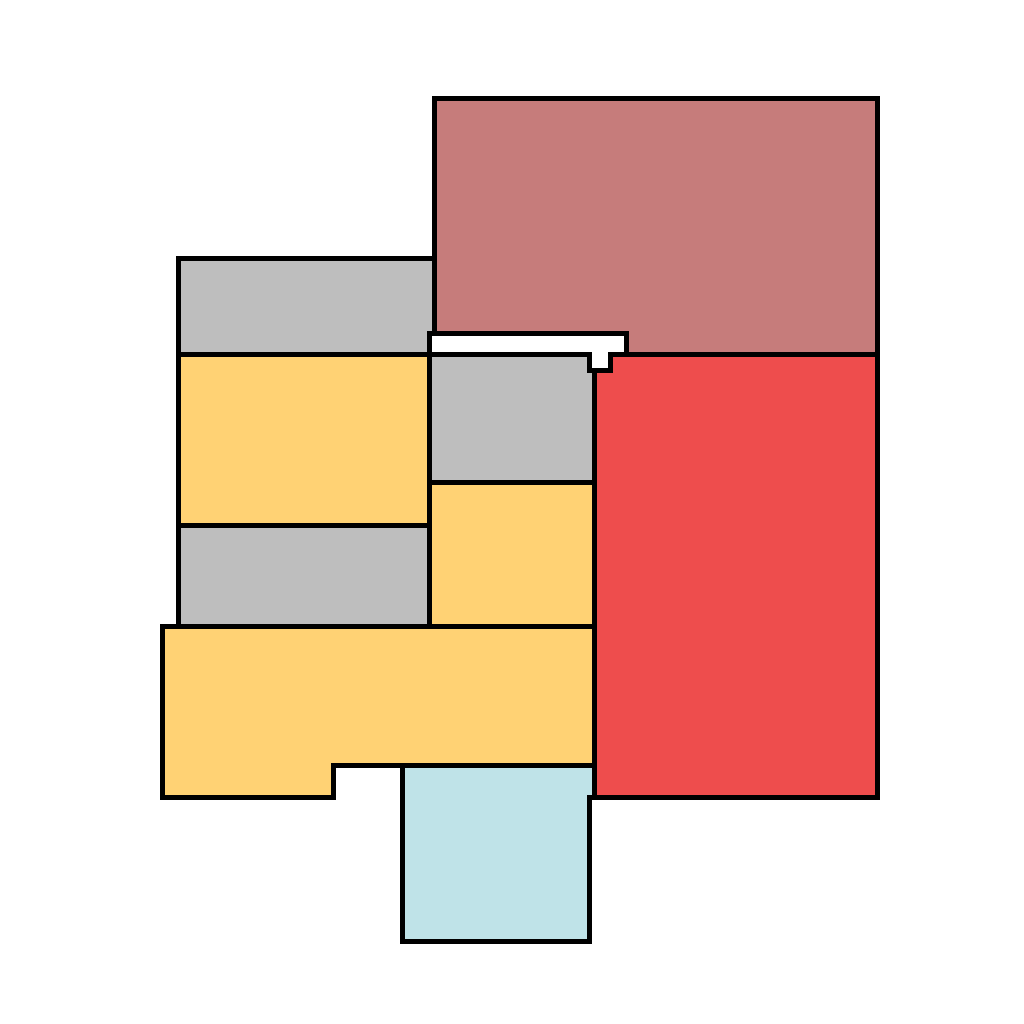

In [7]:
scaled_sep_mask = scale_sep_mask(sep_mask, 3, 3)
blit_rooms(rooms, scaled_sep_mask, out_size=1024)